In [2]:
import h5py  # to read the dataset file

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator  # integer pyplot ticks
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd

from sklearn import metrics

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision.transforms as tfms
from torchvision import models

from fastai.basics import *
from fastai.vision.all import *

import warnings
warnings.filterwarnings('ignore')

/home/tiago/anaconda3/envs/fastai/lib/python3.9/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370151529/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
file = h5py.File('./datasets/Glitches/trainingsetv1d0.h5', mode='r')
metadata = pd.read_csv('datasets/Glitches/trainingset_v1d0_metadata.csv')
train_metadata = metadata.loc[metadata['sample_type']=='train',['sample_type','gravityspy_id','label']]

In [5]:
labels = sorted(train_metadata['label'].unique())
labels.remove('No_Glitch')
labels.remove('None_of_the_Above')

Whistle
ymXQSDePY2 nZqDYJ0AyZ Cm7uYIqc9T hzZdqTJCnU GERIP2qwhb BNEbL8SSXV q4pLfcFjEm qG0H1ivxTB q4pLfcFjEm YPmdN93Fy8 4Id03tZZVG Yskix5Z6b6


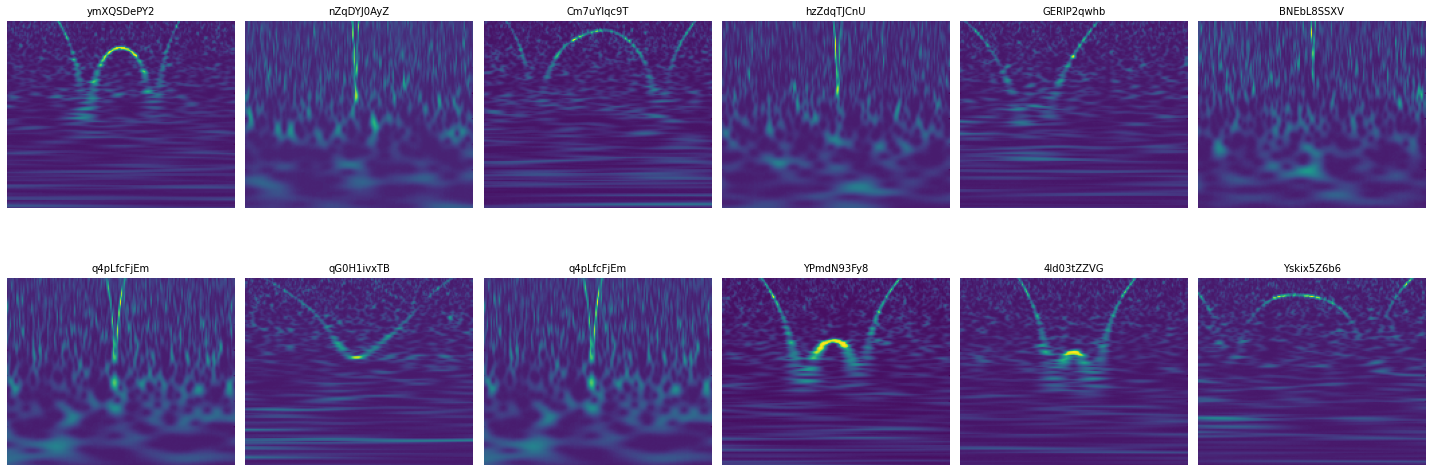

In [630]:
label = labels[19]
print(label)
ids = random.choices(train_metadata.loc[metadata['label'] == label]['gravityspy_id'].to_list(), k=12)
print(*ids)
fig = plt.figure(figsize=(20, 8))
for idx, id_ in enumerate(ids):
    plt.subplot(2, 6, idx+1)
    plt.axis('off')
    img = file[label]['train'][id_]['1.0.png'][0]
    plt.imshow(img)
    plt.title(id_, size=10)
fig.tight_layout()

In [4]:
samples = {
    '1080Lines': ('QaOByCdDbh', 2),
    '1400Ripples': ('51Wmo7vdLa', 1),
    'Air_Compressor': ('RiTNwU1wPp', 1),
    'Blip': ('SKMQNG0MJU', 1),
    'Chirp': ('c69ZJApL8k', 1),
    'Extremely_Loud': ('atMnhTbfXd', 3),
    'Helix': ('GtCr24PjIM', 2),
    'Koi_Fish': ('Px5dgmVAmS', 1),
    'Light_Modulation': ('tMm6tsAkdm', 1),
    'Low_Frequency_Burst': ('gzyv6Mz56X', 1),
    'Low_Frequency_Lines': ('N35xfk1reH', 1),
    'Paired_Doves': ('N5b4FRXonv', 4),
    'Power_Line': ('69lqstU3Dg', 2),
    'Repeating_Blips': ('n5w2dtsF9U', 3),
    'Scattered_Light': ('EPYhrDJK9v', 3),
    'Scratchy': ('Xt4d84LqyG', 3),
    'Tomte': ('3lOPMInLfi', 1),
    'Violin_Mode': ('V00ksgdP5z', 2),
    'Wandering_Line': ('AS6UI4PRa7', 3),
    'Whistle': ('ymXQSDePY2', 2)
}

view_dict = {
    1: '0.5.png',
    2: '1.0.png',
    3: '2.0.png',
    4: '4.0.png'
}

In [540]:
len(train_metadata.loc[metadata['label'] == label]['gravityspy_id'].to_list())

318

In [227]:
2048/11

186.1818181818182

In [79]:
times = np.linspace(-.25, .25, 5)
times

array([-0.25 , -0.125,  0.   ,  0.125,  0.25 ])

In [306]:
np.max(file['Extremely_Loud']['train']['TMCutKakEp']['0.5.png'][0])

0.08322275

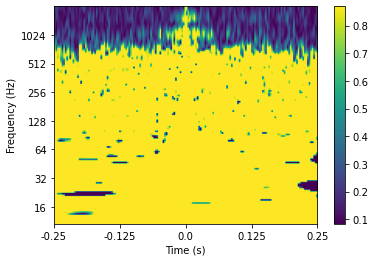

In [313]:
fig, ax = plt.subplots()
im = ax.imshow(file['Extremely_Loud']['train']['yNA8c3b1gX']['0.5.png'][0], extent=[-.25,.25,8,2048], aspect=140/170*0.5/2038)
#ax.tick_params(axis='both', which='both', length=0)
ax.set_xticks(times, [f'{time:.3g}' if time != 0 else '0.0' for time in times ])
ax.set_yticks(freq_pos, [f'{freq:.0f}' for freq in freqs]);
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (Hz)')
cbar = fig.colorbar(im)

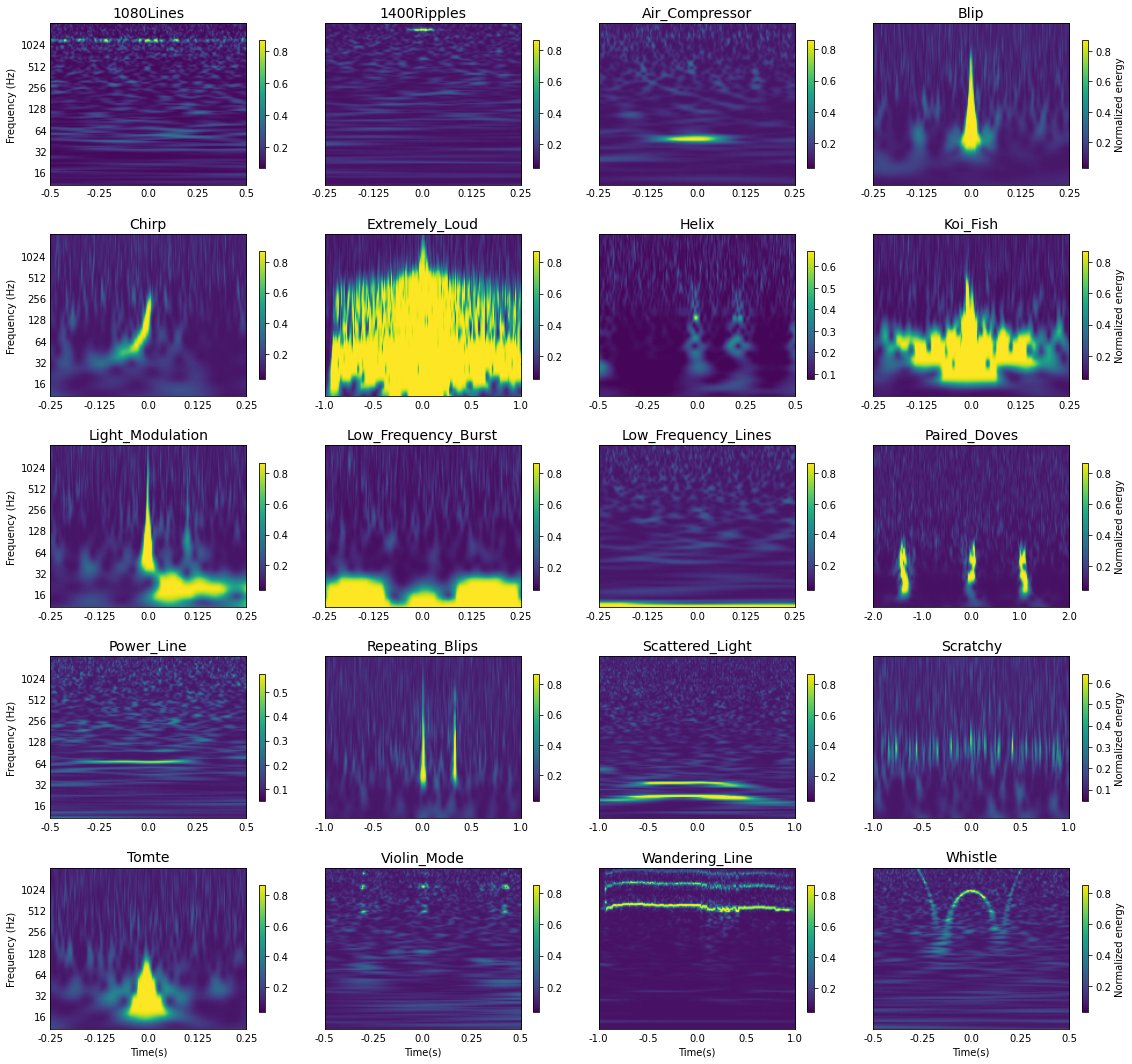

In [60]:
fig, axes = plt.subplots(5, 4, figsize=(16, 15), sharey=True)

ids = []
freq_pos = np.linspace(-100, 2048, 9)[1:-1]
freqs = np.logspace(3, 11, num=9, base=2)[1:-1]
for idx, label in enumerate(labels):
    ax = axes.flat[idx]
    id_, view = samples[label]
    view = view_dict[view]
    view_time = float(view[:3])
    times = np.linspace(-view_time/2, view_time/2, 5)
    ids.append(id_)
    img = file[label]['train'][id_][view][0]
    img = ax.imshow(img, extent=[-view_time/2,view_time/2,8,2048], aspect=140/170*view_time/2038)
    ax.set_title(f'{label}', size=14)
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xticks(times, [f'{float(time)}' for time in times])
    ax.set_yticks(freq_pos, [f'{freq:.0f}' for freq in freqs]);
    #ax.set_xlabel('Time (s)')
    cbar = plt.colorbar(img, ax=ax, shrink=0.7)
    if (idx + 1) % 4 == 0:
        cbar.set_label('Normalized energy')

for ax in axes[:,0]: ax.set_ylabel('Frequency (Hz)') 
for ax in axes[-1,:]: ax.set_xlabel('Time(s)') 
fig.tight_layout()

fig.savefig('figs/glitch_classes.png', dpi=300)

In [8]:
columns = ['class_no', 'class_name', 'n_samples']
dset_classes = pd.DataFrame(columns=columns)

In [9]:
labels = sorted(train_metadata['label'].unique())

In [46]:
total_samples = {}
for idx, label in enumerate(labels):
    n_samples = len(metadata.loc[metadata['label'] == label])
    total_samples[label] = n_samples
    print(f'{idx:<2}: {label:<20}: {n_samples:>4} samples')
    dset_classes.loc[len(dset_classes.index)] = [idx, label, n_samples]
print(f'Total {sum(total_samples.values()):>24} samples')

0 : 1080Lines           :  328 samples
1 : 1400Ripples         :  232 samples
2 : Air_Compressor      :   58 samples
3 : Blip                : 1869 samples
4 : Chirp               :   66 samples
5 : Extremely_Loud      :  454 samples
6 : Helix               :  279 samples
7 : Koi_Fish            :  830 samples
8 : Light_Modulation    :  573 samples
9 : Low_Frequency_Burst :  657 samples
10: Low_Frequency_Lines :  453 samples
11: No_Glitch           :  181 samples
12: None_of_the_Above   :   88 samples
13: Paired_Doves        :   27 samples
14: Power_Line          :  453 samples
15: Repeating_Blips     :  285 samples
16: Scattered_Light     :  459 samples
17: Scratchy            :  354 samples
18: Tomte               :  116 samples
19: Violin_Mode         :  472 samples
20: Wandering_Line      :   44 samples
21: Whistle             :  305 samples
Total                     8583 samples


In [12]:
len(metadata.loc[metadata['label'] == 'Whistle'])

305

In [15]:
metadata.columns

Index(['gravityspy_id', 'label', 'sample_type'], dtype='object')

In [52]:
subset_samples = {'train': 0, 'validation': 0, 'test': 0}
print('No: Class name          : Train| Valid| Test')
for idx, label in enumerate(labels):
    n_samples = []
    for sample_type in ('train', 'validation', 'test'):
        n = len(metadata.loc[(metadata['label'] == label) & (metadata['sample_type'] == sample_type)])
        n_samples.append(n)
        subset_samples[sample_type] += n
    print(f'{idx:<2}: {label:<20}: {n_samples[0]:>4} | {n_samples[1]:>4} | {n_samples[2]:>4}'
          f' | {n_samples[0]/total_samples[label]:.1%} | {n_samples[1]/total_samples[label]:.1%} | {n_samples[2]/total_samples[label]:.1%}')
totals = list(subset_samples.values())
n_total_samples = sum(total_samples.values())
print(f'Total {"":>17} : {totals[0]} | {totals[1]} | {totals[2]} | {totals[0]/n_total_samples:.1%} | {totals[1]/n_total_samples:.1%} | {totals[2]/n_total_samples:.1%}')

No: Class name          : Train| Valid| Test
0 : 1080Lines           :  230 |   49 |   49 | 70.1% | 14.9% | 14.9%
1 : 1400Ripples         :  162 |   35 |   35 | 69.8% | 15.1% | 15.1%
2 : Air_Compressor      :   41 |    8 |    9 | 70.7% | 13.8% | 15.5%
3 : Blip                : 1308 |  281 |  280 | 70.0% | 15.0% | 15.0%
4 : Chirp               :   46 |   10 |   10 | 69.7% | 15.2% | 15.2%
5 : Extremely_Loud      :  318 |   68 |   68 | 70.0% | 15.0% | 15.0%
6 : Helix               :  195 |   42 |   42 | 69.9% | 15.1% | 15.1%
7 : Koi_Fish            :  581 |  125 |  124 | 70.0% | 15.1% | 14.9%
8 : Light_Modulation    :  401 |   86 |   86 | 70.0% | 15.0% | 15.0%
9 : Low_Frequency_Burst :  460 |   99 |   98 | 70.0% | 15.1% | 14.9%
10: Low_Frequency_Lines :  317 |   68 |   68 | 70.0% | 15.0% | 15.0%
11: No_Glitch           :  127 |   27 |   27 | 70.2% | 14.9% | 14.9%
12: None_of_the_Above   :   62 |   13 |   13 | 70.5% | 14.8% | 14.8%
13: Paired_Doves        :   19 |    4 |    4 | 70.4% | 14.

In [10]:
total_samples = 0
for idx, label in enumerate(labels):
    n_samples = len(metadata.loc[metadata['label'] == label]['gravityspy_id'].to_list())
    total_samples += n_samples
    print(f'{idx:<2}: {label:<20}: {n_samples:>4} samples')
    dset_classes.loc[len(dset_classes.index)] = [idx, label, n_samples]
print(f'Total {total_samples:>24} samples')

0 : 1080Lines           :  328 samples
1 : 1400Ripples         :  232 samples
2 : Air_Compressor      :   58 samples
3 : Blip                : 1869 samples
4 : Chirp               :   66 samples
5 : Extremely_Loud      :  454 samples
6 : Helix               :  279 samples
7 : Koi_Fish            :  830 samples
8 : Light_Modulation    :  573 samples
9 : Low_Frequency_Burst :  657 samples
10: Low_Frequency_Lines :  453 samples
11: No_Glitch           :  181 samples
12: None_of_the_Above   :   88 samples
13: Paired_Doves        :   27 samples
14: Power_Line          :  453 samples
15: Repeating_Blips     :  285 samples
16: Scattered_Light     :  459 samples
17: Scratchy            :  354 samples
18: Tomte               :  116 samples
19: Violin_Mode         :  472 samples
20: Wandering_Line      :   44 samples
21: Whistle             :  305 samples
Total                     8583 samples


In [664]:
dset_classes

,class_no,class_name,n_samples
0,0,1080Lines,328
1,1,1400Ripples,232
2,2,Air_Compressor,58
3,3,Blip,1869
4,4,Chirp,66
5,5,Extremely_Loud,454
6,6,Helix,279
7,7,Koi_Fish,830
8,8,Light_Modulation,573
9,9,Low_Frequency_Burst,657


In [665]:
dset_classes.to_latex(index=False)

'\\begin{tabular}{lll}\n\\toprule\nclass\\_no &          class\\_name & n\\_samples \\\\\n\\midrule\n       0 &           1080Lines &       328 \\\\\n       1 &         1400Ripples &       232 \\\\\n       2 &      Air\\_Compressor &        58 \\\\\n       3 &                Blip &      1869 \\\\\n       4 &               Chirp &        66 \\\\\n       5 &      Extremely\\_Loud &       454 \\\\\n       6 &               Helix &       279 \\\\\n       7 &            Koi\\_Fish &       830 \\\\\n       8 &    Light\\_Modulation &       573 \\\\\n       9 & Low\\_Frequency\\_Burst &       657 \\\\\n      10 & Low\\_Frequency\\_Lines &       453 \\\\\n      11 &           No\\_Glitch &       181 \\\\\n      12 &   None\\_of\\_the\\_Above &        88 \\\\\n      13 &        Paired\\_Doves &        27 \\\\\n      14 &          Power\\_Line &       453 \\\\\n      15 &     Repeating\\_Blips &       285 \\\\\n      16 &     Scattered\\_Light &       459 \\\\\n      17 &            Scratchy &  

In [666]:
with open('./dset_classes.tex', 'w') as f:
    dset_classes.to_latex(f, index=False)

In [22]:
val_metadata = metadata.loc[metadata['sample_type']=='validation',['sample_type','gravityspy_id','label']]

WYsyGNwN0i pIXrNfiZ01 pIXrNfiZ01 bPqZlKqkIl Qt7U4h5iK6 k5QzM8QvZc Qt7U4h5iK6 lrrFCS1M5j lrrFCS1M5j N5b4FRXonv bhAmY6PCNM lrrFCS1M5j


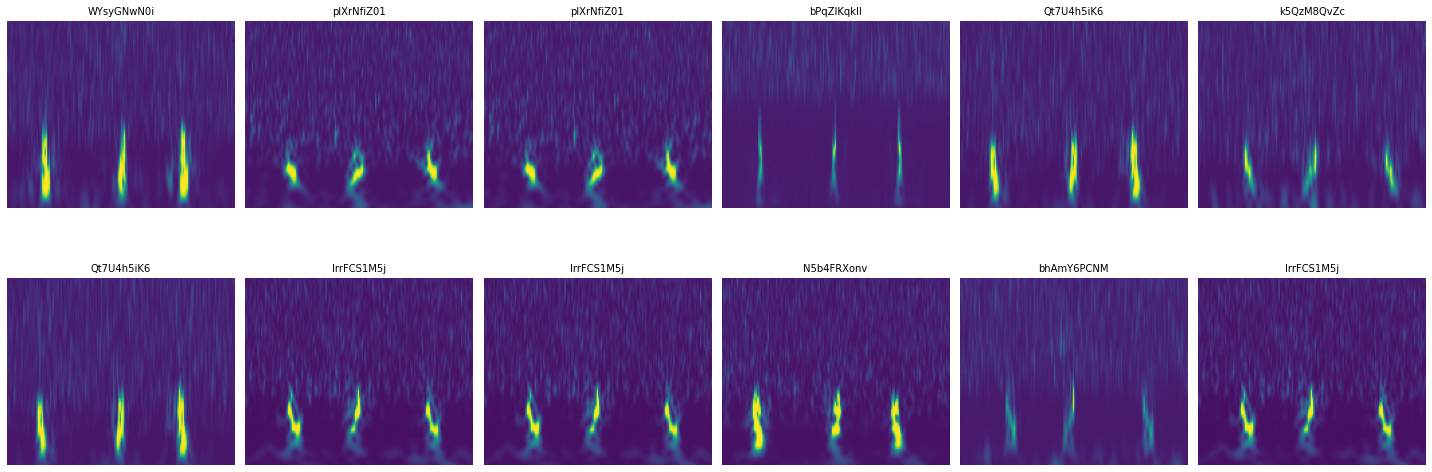

In [9]:
label = "Paired_Doves"
ids = random.choices(train_metadata.loc[metadata['label'] == label]['gravityspy_id'].to_list(), k=12)
print(*ids)
fig = plt.figure(figsize=(20, 8))
for idx, id_ in enumerate(ids):
    plt.subplot(2, 6, idx+1)
    plt.axis('off')
    img = file[label]['train'][id_]['4.0.png'][0]
    plt.imshow(img)
    plt.title(id_, size=10)
fig.tight_layout()

N1kAm9Ytrb N1kAm9Ytrb PXSOCzhbhH PXSOCzhbhH N1kAm9Ytrb PXSOCzhbhH C8P6LsjSSV C8P6LsjSSV N1kAm9Ytrb PXSOCzhbhH 6LWiXxFDne 6LWiXxFDne


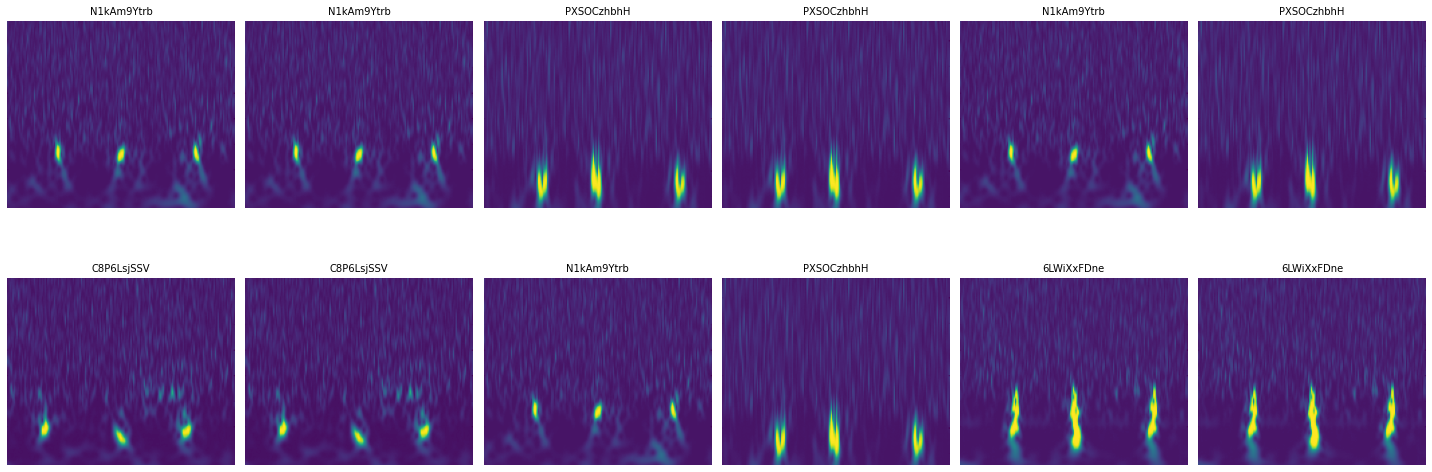

In [24]:
label = "Paired_Doves"
ids = random.choices(val_metadata.loc[metadata['label'] == label]['gravityspy_id'].to_list(), k=12)
print(*ids)
fig = plt.figure(figsize=(20, 8))
for idx, id_ in enumerate(ids):
    plt.subplot(2, 6, idx+1)
    plt.axis('off')
    img = file[label]['validation'][id_]['4.0.png'][0]
    plt.imshow(img)
    plt.title(id_, size=10)
fig.tight_layout()

C3u37TUSuR fCLFP2lbtM v2ijegGEcV WpEQtOZqk5 j6lMdaelxw k891qgSF16 cnqMpr3Dlj tTPzuvso4O UxWI33U0Wd VBw5VpJp4G p9uyAW3ntj e6R3kJOXbm eLGHJoVtO4 xGAcKSzAiF 1pWDp3xjUi QKzXKa2sdV MPxLccdPH2 eKF3oHeVPj


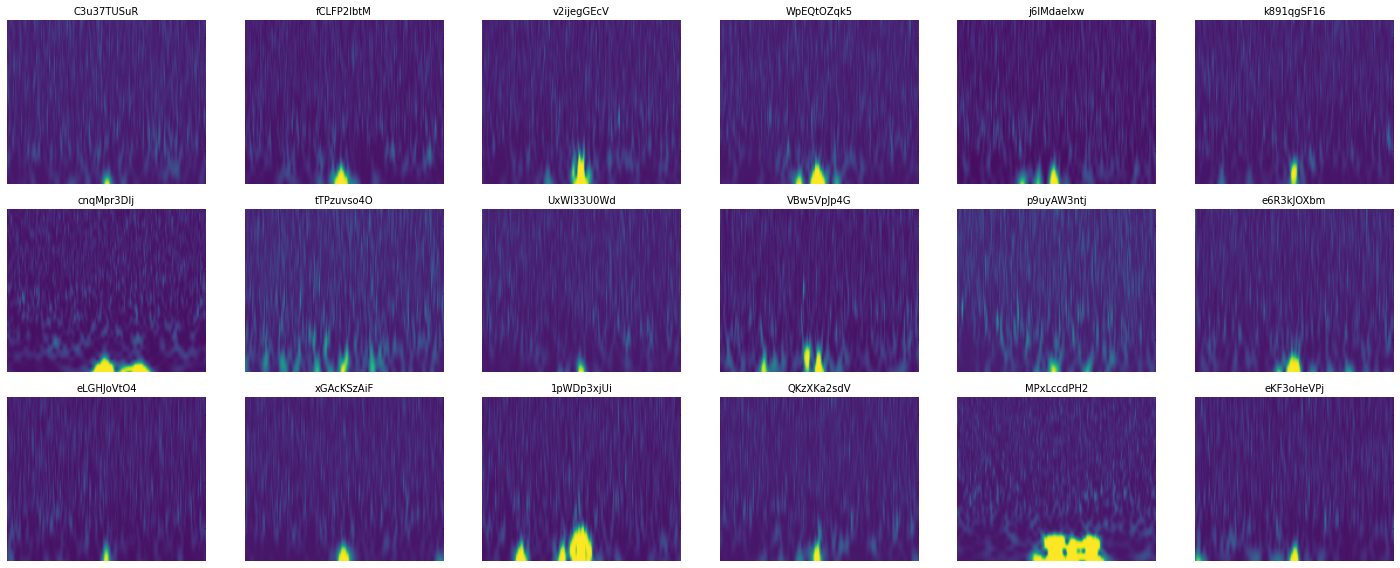

In [52]:
label = "Low_Frequency_Burst"
ids = random.choices(train_metadata.loc[metadata['label'] == label]['gravityspy_id'].to_list(), k=18)
print(*ids)
fig = plt.figure(figsize=(20, 8))
for idx, id_ in enumerate(ids):
    plt.subplot(3, 6, idx+1)
    plt.axis('off')
    img = file[label]['train'][id_]['4.0.png'][0]
    plt.imshow(img)
    plt.title(id_, size=10)
fig.tight_layout()

XBByERytMY LwxvRHWdHW nc068mAPj9 9t7roHbTly 9t7roHbTly l1Slp4pK47 uCIe6DOZMA VXw4KBWl5g fYg3tcEYD4 RqbRYSYwcC RqbRYSYwcC wPsK53P4or wPsK53P4or RqbRYSYwcC J76kRUQauA WUvoytNn1B xsjIluyVhH calgZuPS9A


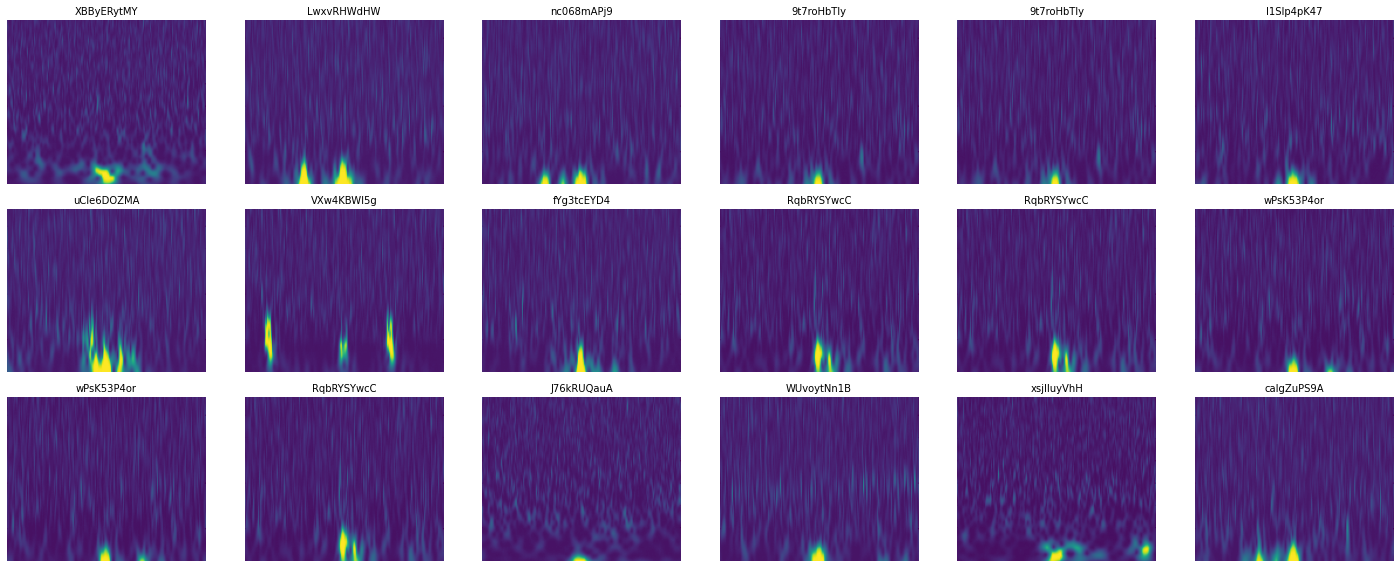

In [39]:
label = "Low_Frequency_Burst"
ids = random.choices(val_metadata.loc[metadata['label'] == label]['gravityspy_id'].to_list(), k=18)
print(*ids)
fig = plt.figure(figsize=(20, 8))
for idx, id_ in enumerate(ids):
    plt.subplot(3, 6, idx+1)
    plt.axis('off')
    img = file[label]['validation'][id_]['4.0.png'][0]
    plt.imshow(img)
    plt.title(id_, size=10)
fig.tight_layout()